Imports

In [1]:
import loss_landscapes
import torch
from HGNN.train import CNN, dataLoader
from HGNN.train.configParser import ConfigParser
import os
import numpy as np
from tqdm.auto import tqdm 
import copy

Cuda

In [2]:
cuda=6

# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)

using cuda 6


Parameters

In [3]:
# experiment_params = {
#             "image_path": "INHS_cropped",
#             "suffix": "biology_paper_cleaned_200max",
#             "img_res": 448,
#             "augmented": True,
#             "batchSize": 128,
#             "learning_rate": 0.1,
#             "numOfTrials": 1,
#             "fc_layers": 1,
#             "modelType": "BB",
#             "lambda": 0.01,
#             "unsupervisedOnTest": False,
#             "tl_model": "ResNet18",
#             "link_layer": "avgpool"
#         }
# model_path = "/home/elhamod/HGNN/experiments/biology_paper_surfaceExperiments_BB_lr_largeBatch/models/8d50d7c9daa5d26371050c2e66f8cb6fb23a94d007db9dbc8bc48770"
# experimentName = "biology_paper_surfaceExperiments_BB_lr_largeBatch"


experiment_params = {"image_path": "INHS_cropped", "suffix": "biology_paper_cleaned_15max", "img_res": 448, "augmented": True, "batchSize": 64, "learning_rate": 0.0001, "numOfTrials": 1, "fc_layers": 1, "modelType": "HGNN_add", "lambda": 0.01, "unsupervisedOnTest": False, "tl_model": "ResNet18", "link_layer": "avgpool"}
model_path = "/home/elhamod/HGNN/experiments/biology_paper_surfaceExperiments_HGNN_datasets/models/af109a6b3598cfb56a4f87b4ab1167d63ec855654e268e5ebb3f2593"
experimentName = "biology_paper_surfaceExperiments_HGNN_datasets"

experimentsPath = "/home/elhamod/HGNN/experiments/" 
dataPath = "/raid/elhamod/Fish"

normalize = 'layer' #
Do_pca = True
STEPS=20 # always even number
loader_id="test" # 'test', 'train'

In [4]:
coord_Tracker_path = os.path.join(model_path, 'coordinates', normalize, str(STEPS), loader_id)
pca_path = os.path.join(model_path, 'coordinates')
if not os.path.exists(coord_Tracker_path):
    os.makedirs(coord_Tracker_path)

Loading dataset

In [5]:
experimentPathAndName = os.path.join(experimentsPath, experimentName)
config_parser = ConfigParser(experimentsPath, dataPath, experimentName)
datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)
datasetManager.updateParams(config_parser.fixPaths(experiment_params))
train_loader, validation_loader, test_loader = datasetManager.getLoaders()
architecture = {
    "fine": len(train_loader.dataset.csv_processor.getFineList()),
    "coarse" : len(train_loader.dataset.csv_processor.getCoarseList())
}

Creating datasets...
Creating datasets... Done.
Creating loaders...
Creating loaders... Done.


Model loading

In [6]:
model_paths = []

i=0
while(True):
    p = os.path.join(model_path, "iterations", "iteration{0}.pt".format(i))
    if os.path.exists(p):
        model_paths.append(p)
        i = i+1
    else:
        model_paths.append(os.path.join(model_path, "iterations", "finalModel.pt"))
        print(i, " models added")
        break

38  models added


In [7]:
models = []
for model_path in tqdm(model_paths):
    model = CNN.create_model(architecture, experiment_params)
    model.load_state_dict(torch.load(os.path.join(model_path))) # , map_location=torch.device('cpu')
    model.eval()
    models.append(model)

Define loss function and metric

In [8]:
# import time

class BGNN_loss(loss_landscapes.Metric):
    def __init__(self, loader, lambda_, isDSN):
        self.criterion = torch.nn.CrossEntropyLoss()
        self.isDSN = isDSN
        self.lambda_ = lambda_
        self.loader = loader
        
        self.inputs = []
        self.target = []
        self.meta_target = []
        self.index = -1
        
    def get_next(self):
        if len(self.inputs) == 0:
            for batch in self.loader:
                self.inputs.append(batch["image"])
                self.target.append(batch["fine"])
                self.meta_target.append(batch["coarse"])
        self.index = self.index+1
        if self.index==len(self.inputs):
            self.index=-1
            return None, None, None
        return self.inputs[self.index], self.target[self.index], self.meta_target[self.index]

    def __call__(self, model_wrapper) -> float:
#         s = time.time()
        
        inputs, target, meta_target = self.get_next()
        while inputs is not None:
            if torch.cuda.is_available():
                self.criterion = self.criterion.cuda()
                inputs = inputs.cuda()
                target = target.cuda()
                meta_target = meta_target.cuda()
            
            batch_size = inputs.shape[0]
                
            output = model_wrapper.forward(inputs)
            print(output)
            
            loss_coarse = 0
            if output["coarse"] is not None:
                loss_coarse = self.criterion(output["coarse"], meta_target if not self.isDSN else target)
            loss_fine = self.criterion(output["fine"], target)
            loss = loss_fine + self.lambda_*loss_coarse
            loss = batch_size*loss
            
            inputs, target, meta_target = self.get_next()
            
#             print(time.time()-s)
#             s = time.time()

        print(len(self.loader.dataset))
        loss = loss/len(self.loader.dataset)
        loss = loss.detach()
        print(loss)
        print("--")
        if torch.cuda.is_available():
            loss = loss.cpu()
        
        return loss.numpy()

In [9]:
import time

class BGNN_loss3(loss_landscapes.Metric):
    def __init__(self, loader, lambda_, isDSN):
        self.criterion = torch.nn.CrossEntropyLoss()
        self.isDSN = isDSN
        self.lambda_ = lambda_
        self.loader = loader
        self.data_iter = iter(loader)

    def __call__(self, model_wrapper) -> float:
        s = time.time()
        
        next_batch = self.data_iter.next() # start loading the first batch
#         print(next_batch)
#         next_batch = [ _.cuda(non_blocking=True) for _ in next_batch ]  # with pin_memory=True and non_blocking=True, this will copy data to GPU non blockingly

        for i in range(len(self.loader)):
            batch = next_batch 
            if i + 1 != len(self.loader): 
                # start copying data of next batch
                next_batch = self.data_iter.next()
#                 next_batch = [ _.cuda(async=True) for _ in next_batch]

            inputs = batch["image"]
            target = batch["fine"]
            meta_target = batch["coarse"]
            if torch.cuda.is_available():
                self.criterion = self.criterion.cuda()
                inputs = inputs.cuda()
                target = target.cuda()
                meta_target = meta_target.cuda()
            
            batch_size = inputs.shape[0]
                
            
            output = model_wrapper.forward(inputs)
            
            
            loss_coarse = 0
            if output["coarse"] is not None:
                loss_coarse = self.criterion(output["coarse"], meta_target if not self.isDSN else target)
            loss_fine = self.criterion(output["fine"], target)
            loss = loss_fine + self.lambda_*loss_coarse
            loss = batch_size*loss
            
            print(time.time()-s)
            s = time.time()

        loss = loss/len(self.loader.dataset)
        loss = loss.detach()
        if torch.cuda.is_available():
            loss = loss.cpu()
        
        return loss.numpy()

In [10]:
class BGNN_loss2(loss_landscapes.Loss):
    def __init__(self, inputs, target, meta_target, lambda_, isDSN):
        criterion = torch.nn.CrossEntropyLoss()
        if torch.cuda.is_available():
            criterion = criterion.cuda()
            inputs = inputs.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
        super().__init__(criterion, inputs, target)
        self.isDSN = isDSN
        self.lambda_ = lambda_
        self.meta_target = meta_target

    def __call__(self, model_wrapper) -> float:
        output = model_wrapper.forward(self.inputs)
#         print(output)
        
        loss_coarse = 0
        if output["coarse"] is not None:
            loss_coarse = self.loss_fn(output["coarse"], self.meta_target if not self.isDSN else self.target)
        loss_fine = self.loss_fn(output["fine"], self.target)
        loss = loss_fine + self.lambda_*loss_coarse
        print(loss_coarse, loss_fine, loss)
        print('----')
        
        loss = loss.detach()
        if torch.cuda.is_available():
            loss = loss.cpu()
        
        return loss.numpy()

In [11]:
# grid_batchSize = len(test_loader.dataset)

# num_of_workers = 8
# test_loader = torch.utils.data.DataLoader(test_loader.dataset, batch_size=grid_batchSize, num_workers=num_of_workers, pin_memory=True)
# batch = next(iter(test_loader))
# inputs = batch["image"]
# target = batch["fine"]
# meta_target = batch["coarse"]

In [12]:
def get_loss_params(loader):
    loader2 = torch.utils.data.DataLoader(loader.dataset, batch_size=len(loader.dataset))
    batch = next(iter(loader2))
    inputs = batch["image"]
    target = batch["fine"]
    meta_target = batch["coarse"]
    return inputs, target, meta_target

In [13]:
if loader_id == 'validation':
    loader = validation_loader
elif loader_id == 'test':
    loader = test_loader
else:
    loader = train_loader
inputs, target, meta_target = get_loss_params(loader)

In [14]:
# metric = BGNN_loss3(test_loader, experiment_params["lambda"], False) #TODO: need to automate these params
# metric = BGNN_loss(test_loader, experiment_params["lambda"], False) #TODO: need to automate these params
metric = BGNN_loss2(inputs, target, meta_target, experiment_params["lambda"], False) #TODO: need to automate these params

In [15]:
coord_Tracker = loss_landscapes.Coordinates_tracker(path=coord_Tracker_path, dirs_path=pca_path, steps_=STEPS)

PCA to get primary directions

In [16]:
if Do_pca:
    if not coord_Tracker.load_dirs():
        coord_Tracker.update_directions(loss_landscapes.get_best_fit_orthogonal_bases_pca(models))
        coord_Tracker.save()
        print("saved")
    else:
        print("loaded")

loaded


Save/load data file

In [17]:
loss_data_file = os.path.join(coord_Tracker_path, "loss_surface_data")
try:
    loss_data = np.load(loss_data_file)
    print("loaded")
except:
    loss_data = loss_landscapes.random_plane(models[-1], metric, normalization=normalize, deepcopy_model=True, coord_Tracker=coord_Tracker, other_models=models[:-1])
    np.save(loss_data_file, loss_data)
    print("saved")

1.0000000482439666
end-----
1.0
end-----
1.0000000615900284
end-----
1.0000000362321775
end-----
1.0
end-----
1.0
end-----
0.9999999492623082
end-----
1.0000000593573526
end-----
1.0
end-----
1.0000000400099762
end-----
1.0000000330179826
end-----
1.0
end-----
0.9999999464579513
end-----
1.000000041637391
end-----
0.9999999233842437
end-----
1.0000000299486718
end-----
1.0000000366408643
end-----
1.000000056868567
end-----
1.0
end-----
1.0000000311903616
end-----
1.0
end-----
1.0000000467154364
end-----
0.9999999613260695
end-----
1.0
end-----
0.9999999556050992
end-----
1.0
end-----
1.0
end-----
1.0
end-----
1.0
end-----
0.9999999553960549
end-----
0.9999999384905766
end-----
1.0
end-----
1.0000000427811762
end-----
1.0000000414239765
end-----
1.0
end-----
1.0
end-----
0.9999999462521504
end-----
1.0
end-----
1.0
end-----
0.9999999481973494
end-----
1.0
end-----
1.0
end-----
0.9999999696333335
end-----
0.9999999006309684
end-----
1.0
end-----
0.9999999671877057
end-----
0.999999947603

tensor(3.5221, device='cuda:6') tensor(8.1284, device='cuda:6') tensor(8.1637, device='cuda:6')
----
tensor(3.0486, device='cuda:6') tensor(7.1533, device='cuda:6') tensor(7.1838, device='cuda:6')
----
tensor(2.7266, device='cuda:6') tensor(6.5122, device='cuda:6') tensor(6.5394, device='cuda:6')
----
tensor(2.5594, device='cuda:6') tensor(6.1112, device='cuda:6') tensor(6.1368, device='cuda:6')
----
tensor(2.2587, device='cuda:6') tensor(5.7913, device='cuda:6') tensor(5.8139, device='cuda:6')
----
tensor(1.9126, device='cuda:6') tensor(5.4499, device='cuda:6') tensor(5.4690, device='cuda:6')
----
tensor(1.6809, device='cuda:6') tensor(4.9098, device='cuda:6') tensor(4.9266, device='cuda:6')
----
tensor(1.6020, device='cuda:6') tensor(4.4051, device='cuda:6') tensor(4.4211, device='cuda:6')
----
tensor(1.5771, device='cuda:6') tensor(4.1485, device='cuda:6') tensor(4.1643, device='cuda:6')
----
tensor(1.5057, device='cuda:6') tensor(3.9346, device='cuda:6') tensor(3.9497, device='cuda

tensor(1.6924, device='cuda:6') tensor(3.8865, device='cuda:6') tensor(3.9034, device='cuda:6')
----
tensor(1.8091, device='cuda:6') tensor(3.9224, device='cuda:6') tensor(3.9405, device='cuda:6')
----
tensor(1.9899, device='cuda:6') tensor(3.9049, device='cuda:6') tensor(3.9248, device='cuda:6')
----
tensor(1.8434, device='cuda:6') tensor(3.6586, device='cuda:6') tensor(3.6771, device='cuda:6')
----
tensor(1.6379, device='cuda:6') tensor(3.4320, device='cuda:6') tensor(3.4484, device='cuda:6')
----
tensor(1.5092, device='cuda:6') tensor(3.1697, device='cuda:6') tensor(3.1848, device='cuda:6')
----
tensor(1.4094, device='cuda:6') tensor(2.9282, device='cuda:6') tensor(2.9423, device='cuda:6')
----
tensor(1.3958, device='cuda:6') tensor(2.8076, device='cuda:6') tensor(2.8216, device='cuda:6')
----
tensor(1.3087, device='cuda:6') tensor(2.8659, device='cuda:6') tensor(2.8789, device='cuda:6')
----
tensor(1.2274, device='cuda:6') tensor(3.0407, device='cuda:6') tensor(3.0529, device='cuda

tensor(2.7096, device='cuda:6') tensor(6.5585, device='cuda:6') tensor(6.5856, device='cuda:6')
----
tensor(2.4174, device='cuda:6') tensor(5.8228, device='cuda:6') tensor(5.8470, device='cuda:6')
----
tensor(2.1423, device='cuda:6') tensor(5.3442, device='cuda:6') tensor(5.3656, device='cuda:6')
----
tensor(1.9551, device='cuda:6') tensor(5.0022, device='cuda:6') tensor(5.0218, device='cuda:6')
----
tensor(1.7269, device='cuda:6') tensor(4.6973, device='cuda:6') tensor(4.7146, device='cuda:6')
----
tensor(1.4768, device='cuda:6') tensor(4.4070, device='cuda:6') tensor(4.4218, device='cuda:6')
----
tensor(1.3068, device='cuda:6') tensor(4.0184, device='cuda:6') tensor(4.0314, device='cuda:6')
----
tensor(1.2238, device='cuda:6') tensor(3.6619, device='cuda:6') tensor(3.6741, device='cuda:6')
----
tensor(1.1470, device='cuda:6') tensor(3.3602, device='cuda:6') tensor(3.3716, device='cuda:6')
----
tensor(1.0733, device='cuda:6') tensor(3.0793, device='cuda:6') tensor(3.0901, device='cuda

tensor(1.3175, device='cuda:6') tensor(3.6510, device='cuda:6') tensor(3.6642, device='cuda:6')
----
tensor(1.5302, device='cuda:6') tensor(3.7115, device='cuda:6') tensor(3.7268, device='cuda:6')
----
tensor(1.7122, device='cuda:6') tensor(3.6370, device='cuda:6') tensor(3.6541, device='cuda:6')
----
tensor(1.6991, device='cuda:6') tensor(3.3932, device='cuda:6') tensor(3.4102, device='cuda:6')
----
tensor(1.6182, device='cuda:6') tensor(3.0806, device='cuda:6') tensor(3.0968, device='cuda:6')
----
tensor(1.4757, device='cuda:6') tensor(2.6851, device='cuda:6') tensor(2.6998, device='cuda:6')
----
tensor(1.1806, device='cuda:6') tensor(2.2297, device='cuda:6') tensor(2.2415, device='cuda:6')
----
tensor(0.9390, device='cuda:6') tensor(2.0309, device='cuda:6') tensor(2.0403, device='cuda:6')
----
tensor(0.8682, device='cuda:6') tensor(2.0147, device='cuda:6') tensor(2.0234, device='cuda:6')
----
tensor(0.8444, device='cuda:6') tensor(2.1208, device='cuda:6') tensor(2.1293, device='cuda

tensor(1.9380, device='cuda:6') tensor(5.3089, device='cuda:6') tensor(5.3282, device='cuda:6')
----
tensor(1.7408, device='cuda:6') tensor(4.7967, device='cuda:6') tensor(4.8141, device='cuda:6')
----
tensor(1.5674, device='cuda:6') tensor(4.4420, device='cuda:6') tensor(4.4576, device='cuda:6')
----
tensor(1.3850, device='cuda:6') tensor(4.2233, device='cuda:6') tensor(4.2372, device='cuda:6')
----
tensor(1.2131, device='cuda:6') tensor(3.9984, device='cuda:6') tensor(4.0105, device='cuda:6')
----
tensor(1.0248, device='cuda:6') tensor(3.7094, device='cuda:6') tensor(3.7197, device='cuda:6')
----
tensor(0.9120, device='cuda:6') tensor(3.2680, device='cuda:6') tensor(3.2771, device='cuda:6')
----
tensor(0.8184, device='cuda:6') tensor(2.8541, device='cuda:6') tensor(2.8623, device='cuda:6')
----
tensor(0.7536, device='cuda:6') tensor(2.4614, device='cuda:6') tensor(2.4689, device='cuda:6')
----
tensor(0.7160, device='cuda:6') tensor(2.1677, device='cuda:6') tensor(2.1748, device='cuda

tensor(1.2631, device='cuda:6') tensor(3.4649, device='cuda:6') tensor(3.4775, device='cuda:6')
----
tensor(1.4805, device='cuda:6') tensor(3.3705, device='cuda:6') tensor(3.3854, device='cuda:6')
----
tensor(1.5883, device='cuda:6') tensor(3.3421, device='cuda:6') tensor(3.3580, device='cuda:6')
----
tensor(1.5779, device='cuda:6') tensor(3.0716, device='cuda:6') tensor(3.0874, device='cuda:6')
----
tensor(1.4699, device='cuda:6') tensor(2.5774, device='cuda:6') tensor(2.5921, device='cuda:6')
----
tensor(1.3184, device='cuda:6') tensor(2.1455, device='cuda:6') tensor(2.1586, device='cuda:6')
----
tensor(1.0272, device='cuda:6') tensor(1.7165, device='cuda:6') tensor(1.7268, device='cuda:6')
----
tensor(0.7140, device='cuda:6') tensor(1.3820, device='cuda:6') tensor(1.3891, device='cuda:6')
----
tensor(0.5826, device='cuda:6') tensor(1.3388, device='cuda:6') tensor(1.3446, device='cuda:6')
----
tensor(0.5649, device='cuda:6') tensor(1.3922, device='cuda:6') tensor(1.3978, device='cuda

tensor(1.4058, device='cuda:6') tensor(4.3011, device='cuda:6') tensor(4.3152, device='cuda:6')
----
tensor(1.2734, device='cuda:6') tensor(4.0392, device='cuda:6') tensor(4.0519, device='cuda:6')
----
tensor(1.0585, device='cuda:6') tensor(3.7934, device='cuda:6') tensor(3.8040, device='cuda:6')
----
tensor(0.9221, device='cuda:6') tensor(3.5217, device='cuda:6') tensor(3.5309, device='cuda:6')
----
tensor(0.7553, device='cuda:6') tensor(3.1335, device='cuda:6') tensor(3.1411, device='cuda:6')
----
tensor(0.6096, device='cuda:6') tensor(2.7510, device='cuda:6') tensor(2.7571, device='cuda:6')
----
tensor(0.5060, device='cuda:6') tensor(2.4366, device='cuda:6') tensor(2.4416, device='cuda:6')
----
tensor(0.4627, device='cuda:6') tensor(2.1483, device='cuda:6') tensor(2.1529, device='cuda:6')
----
tensor(0.4672, device='cuda:6') tensor(1.8557, device='cuda:6') tensor(1.8604, device='cuda:6')
----
tensor(0.4803, device='cuda:6') tensor(1.5334, device='cuda:6') tensor(1.5382, device='cuda

tensor(1.1438, device='cuda:6') tensor(3.3959, device='cuda:6') tensor(3.4073, device='cuda:6')
----
tensor(1.2402, device='cuda:6') tensor(3.0945, device='cuda:6') tensor(3.1069, device='cuda:6')
----
tensor(1.3373, device='cuda:6') tensor(2.8582, device='cuda:6') tensor(2.8716, device='cuda:6')
----
tensor(1.3463, device='cuda:6') tensor(2.6892, device='cuda:6') tensor(2.7026, device='cuda:6')
----
tensor(1.3194, device='cuda:6') tensor(2.2702, device='cuda:6') tensor(2.2834, device='cuda:6')
----
tensor(1.1872, device='cuda:6') tensor(1.7562, device='cuda:6') tensor(1.7681, device='cuda:6')
----
tensor(0.9973, device='cuda:6') tensor(1.3387, device='cuda:6') tensor(1.3487, device='cuda:6')
----
tensor(0.6960, device='cuda:6') tensor(1.0472, device='cuda:6') tensor(1.0541, device='cuda:6')
----
tensor(0.5256, device='cuda:6') tensor(0.9255, device='cuda:6') tensor(0.9308, device='cuda:6')
----
tensor(0.4368, device='cuda:6') tensor(0.9326, device='cuda:6') tensor(0.9369, device='cuda

tensor(1.1308, device='cuda:6') tensor(3.7500, device='cuda:6') tensor(3.7613, device='cuda:6')
----
tensor(0.9029, device='cuda:6') tensor(3.5084, device='cuda:6') tensor(3.5174, device='cuda:6')
----
tensor(0.7874, device='cuda:6') tensor(3.1926, device='cuda:6') tensor(3.2005, device='cuda:6')
----
tensor(0.6858, device='cuda:6') tensor(2.8073, device='cuda:6') tensor(2.8142, device='cuda:6')
----
tensor(0.5091, device='cuda:6') tensor(2.3807, device='cuda:6') tensor(2.3858, device='cuda:6')
----
tensor(0.3978, device='cuda:6') tensor(1.9530, device='cuda:6') tensor(1.9570, device='cuda:6')
----
tensor(0.3563, device='cuda:6') tensor(1.6274, device='cuda:6') tensor(1.6310, device='cuda:6')
----
tensor(0.3435, device='cuda:6') tensor(1.3690, device='cuda:6') tensor(1.3724, device='cuda:6')
----
tensor(0.3454, device='cuda:6') tensor(1.1576, device='cuda:6') tensor(1.1610, device='cuda:6')
----
tensor(0.3557, device='cuda:6') tensor(1.0074, device='cuda:6') tensor(1.0109, device='cuda

tensor(1.1926, device='cuda:6') tensor(3.5394, device='cuda:6') tensor(3.5514, device='cuda:6')
----
tensor(1.2199, device='cuda:6') tensor(3.1827, device='cuda:6') tensor(3.1949, device='cuda:6')
----
tensor(1.1797, device='cuda:6') tensor(2.6209, device='cuda:6') tensor(2.6327, device='cuda:6')
----
tensor(1.1483, device='cuda:6') tensor(2.3380, device='cuda:6') tensor(2.3494, device='cuda:6')
----
tensor(1.1120, device='cuda:6') tensor(1.9692, device='cuda:6') tensor(1.9803, device='cuda:6')
----
tensor(1.0386, device='cuda:6') tensor(1.6161, device='cuda:6') tensor(1.6265, device='cuda:6')
----
tensor(0.8995, device='cuda:6') tensor(1.2563, device='cuda:6') tensor(1.2653, device='cuda:6')
----
tensor(0.8033, device='cuda:6') tensor(0.9426, device='cuda:6') tensor(0.9506, device='cuda:6')
----
tensor(0.6199, device='cuda:6') tensor(0.7684, device='cuda:6') tensor(0.7746, device='cuda:6')
----
tensor(0.4636, device='cuda:6') tensor(0.7013, device='cuda:6') tensor(0.7059, device='cuda

tensor(1.1255, device='cuda:6') tensor(3.5752, device='cuda:6') tensor(3.5864, device='cuda:6')
----
tensor(0.8286, device='cuda:6') tensor(3.1554, device='cuda:6') tensor(3.1637, device='cuda:6')
----
tensor(0.6128, device='cuda:6') tensor(2.7051, device='cuda:6') tensor(2.7112, device='cuda:6')
----
tensor(0.4884, device='cuda:6') tensor(2.2674, device='cuda:6') tensor(2.2722, device='cuda:6')
----
tensor(0.4087, device='cuda:6') tensor(1.8025, device='cuda:6') tensor(1.8066, device='cuda:6')
----
tensor(0.3689, device='cuda:6') tensor(1.3663, device='cuda:6') tensor(1.3700, device='cuda:6')
----
tensor(0.3523, device='cuda:6') tensor(1.0298, device='cuda:6') tensor(1.0333, device='cuda:6')
----
tensor(0.3530, device='cuda:6') tensor(0.8213, device='cuda:6') tensor(0.8249, device='cuda:6')
----
tensor(0.3362, device='cuda:6') tensor(0.7170, device='cuda:6') tensor(0.7204, device='cuda:6')
----
tensor(0.3483, device='cuda:6') tensor(0.6227, device='cuda:6') tensor(0.6262, device='cuda

tensor(1.2657, device='cuda:6') tensor(3.8848, device='cuda:6') tensor(3.8975, device='cuda:6')
----
tensor(1.3121, device='cuda:6') tensor(3.5775, device='cuda:6') tensor(3.5906, device='cuda:6')
----
tensor(1.3508, device='cuda:6') tensor(3.2175, device='cuda:6') tensor(3.2310, device='cuda:6')
----
tensor(1.2295, device='cuda:6') tensor(2.5907, device='cuda:6') tensor(2.6030, device='cuda:6')
----
tensor(1.0690, device='cuda:6') tensor(2.1033, device='cuda:6') tensor(2.1140, device='cuda:6')
----
tensor(0.9732, device='cuda:6') tensor(1.6671, device='cuda:6') tensor(1.6768, device='cuda:6')
----
tensor(0.8508, device='cuda:6') tensor(1.3112, device='cuda:6') tensor(1.3197, device='cuda:6')
----
tensor(0.7611, device='cuda:6') tensor(0.9800, device='cuda:6') tensor(0.9876, device='cuda:6')
----
tensor(0.6913, device='cuda:6') tensor(0.7896, device='cuda:6') tensor(0.7965, device='cuda:6')
----
tensor(0.4952, device='cuda:6') tensor(0.6793, device='cuda:6') tensor(0.6843, device='cuda

tensor(1.2987, device='cuda:6') tensor(3.3580, device='cuda:6') tensor(3.3710, device='cuda:6')
----
tensor(0.8415, device='cuda:6') tensor(2.8561, device='cuda:6') tensor(2.8645, device='cuda:6')
----
tensor(0.5697, device='cuda:6') tensor(2.4476, device='cuda:6') tensor(2.4533, device='cuda:6')
----
tensor(0.4283, device='cuda:6') tensor(1.9233, device='cuda:6') tensor(1.9276, device='cuda:6')
----
tensor(0.4856, device='cuda:6') tensor(1.4429, device='cuda:6') tensor(1.4478, device='cuda:6')
----
tensor(0.4993, device='cuda:6') tensor(0.9988, device='cuda:6') tensor(1.0038, device='cuda:6')
----
tensor(0.5096, device='cuda:6') tensor(0.7289, device='cuda:6') tensor(0.7340, device='cuda:6')
----
tensor(0.4880, device='cuda:6') tensor(0.5885, device='cuda:6') tensor(0.5934, device='cuda:6')
----
tensor(0.4295, device='cuda:6') tensor(0.5517, device='cuda:6') tensor(0.5560, device='cuda:6')
----
tensor(0.3526, device='cuda:6') tensor(0.5624, device='cuda:6') tensor(0.5659, device='cuda

tensor(1.4692, device='cuda:6') tensor(4.4968, device='cuda:6') tensor(4.5115, device='cuda:6')
----
tensor(1.5372, device='cuda:6') tensor(4.1407, device='cuda:6') tensor(4.1561, device='cuda:6')
----
tensor(1.7379, device='cuda:6') tensor(3.7846, device='cuda:6') tensor(3.8020, device='cuda:6')
----
tensor(1.7218, device='cuda:6') tensor(3.3000, device='cuda:6') tensor(3.3172, device='cuda:6')
----
tensor(1.3370, device='cuda:6') tensor(2.7183, device='cuda:6') tensor(2.7316, device='cuda:6')
----
tensor(1.0310, device='cuda:6') tensor(2.1711, device='cuda:6') tensor(2.1814, device='cuda:6')
----
tensor(1.0088, device='cuda:6') tensor(1.5243, device='cuda:6') tensor(1.5344, device='cuda:6')
----
tensor(0.8908, device='cuda:6') tensor(1.1999, device='cuda:6') tensor(1.2088, device='cuda:6')
----
tensor(0.8435, device='cuda:6') tensor(0.8812, device='cuda:6') tensor(0.8896, device='cuda:6')
----
tensor(0.6110, device='cuda:6') tensor(0.7171, device='cuda:6') tensor(0.7232, device='cuda

tensor(1.6435, device='cuda:6') tensor(3.1951, device='cuda:6') tensor(3.2115, device='cuda:6')
----
tensor(1.0524, device='cuda:6') tensor(2.8385, device='cuda:6') tensor(2.8490, device='cuda:6')
----
tensor(0.7417, device='cuda:6') tensor(2.4412, device='cuda:6') tensor(2.4486, device='cuda:6')
----
tensor(0.6052, device='cuda:6') tensor(1.9415, device='cuda:6') tensor(1.9476, device='cuda:6')
----
tensor(0.6476, device='cuda:6') tensor(1.5214, device='cuda:6') tensor(1.5279, device='cuda:6')
----
tensor(0.6878, device='cuda:6') tensor(1.1034, device='cuda:6') tensor(1.1103, device='cuda:6')
----
tensor(0.7024, device='cuda:6') tensor(0.8465, device='cuda:6') tensor(0.8536, device='cuda:6')
----
tensor(0.6058, device='cuda:6') tensor(0.7277, device='cuda:6') tensor(0.7338, device='cuda:6')
----
tensor(0.4384, device='cuda:6') tensor(0.7072, device='cuda:6') tensor(0.7116, device='cuda:6')
----
tensor(0.3538, device='cuda:6') tensor(0.7213, device='cuda:6') tensor(0.7248, device='cuda

tensor(1.7955, device='cuda:6') tensor(5.1666, device='cuda:6') tensor(5.1846, device='cuda:6')
----
tensor(2.2223, device='cuda:6') tensor(4.9425, device='cuda:6') tensor(4.9647, device='cuda:6')
----
tensor(2.4333, device='cuda:6') tensor(4.7191, device='cuda:6') tensor(4.7434, device='cuda:6')
----
tensor(2.4065, device='cuda:6') tensor(4.3042, device='cuda:6') tensor(4.3283, device='cuda:6')
----
tensor(1.9837, device='cuda:6') tensor(3.5750, device='cuda:6') tensor(3.5948, device='cuda:6')
----
tensor(1.6234, device='cuda:6') tensor(2.7216, device='cuda:6') tensor(2.7379, device='cuda:6')
----
tensor(1.4542, device='cuda:6') tensor(2.0010, device='cuda:6') tensor(2.0156, device='cuda:6')
----
tensor(1.3858, device='cuda:6') tensor(1.4532, device='cuda:6') tensor(1.4671, device='cuda:6')
----
tensor(1.2712, device='cuda:6') tensor(1.1774, device='cuda:6') tensor(1.1901, device='cuda:6')
----
tensor(1.0117, device='cuda:6') tensor(1.0462, device='cuda:6') tensor(1.0563, device='cuda

tensor(1.4090, device='cuda:6') tensor(3.2086, device='cuda:6') tensor(3.2226, device='cuda:6')
----
tensor(0.8881, device='cuda:6') tensor(2.8524, device='cuda:6') tensor(2.8613, device='cuda:6')
----
tensor(0.8902, device='cuda:6') tensor(2.4991, device='cuda:6') tensor(2.5080, device='cuda:6')
----
tensor(0.9177, device='cuda:6') tensor(2.1978, device='cuda:6') tensor(2.2070, device='cuda:6')
----
tensor(1.0362, device='cuda:6') tensor(1.8149, device='cuda:6') tensor(1.8253, device='cuda:6')
----
tensor(1.0205, device='cuda:6') tensor(1.3985, device='cuda:6') tensor(1.4087, device='cuda:6')
----
tensor(0.9169, device='cuda:6') tensor(1.1611, device='cuda:6') tensor(1.1703, device='cuda:6')
----
tensor(0.7571, device='cuda:6') tensor(1.0548, device='cuda:6') tensor(1.0624, device='cuda:6')
----
tensor(0.5383, device='cuda:6') tensor(1.0646, device='cuda:6') tensor(1.0700, device='cuda:6')
----
tensor(0.5567, device='cuda:6') tensor(1.1052, device='cuda:6') tensor(1.1108, device='cuda

tensor(2.7346, device='cuda:6') tensor(5.5150, device='cuda:6') tensor(5.5423, device='cuda:6')
----
tensor(2.8919, device='cuda:6') tensor(5.2675, device='cuda:6') tensor(5.2964, device='cuda:6')
----
tensor(2.7683, device='cuda:6') tensor(4.8816, device='cuda:6') tensor(4.9093, device='cuda:6')
----
tensor(2.6934, device='cuda:6') tensor(4.4131, device='cuda:6') tensor(4.4401, device='cuda:6')
----
tensor(2.4057, device='cuda:6') tensor(3.7645, device='cuda:6') tensor(3.7886, device='cuda:6')
----
tensor(2.1088, device='cuda:6') tensor(3.3568, device='cuda:6') tensor(3.3779, device='cuda:6')
----
tensor(1.8376, device='cuda:6') tensor(2.9483, device='cuda:6') tensor(2.9667, device='cuda:6')
----
tensor(1.6752, device='cuda:6') tensor(2.4434, device='cuda:6') tensor(2.4601, device='cuda:6')
----
tensor(1.3929, device='cuda:6') tensor(1.9598, device='cuda:6') tensor(1.9737, device='cuda:6')
----
tensor(1.1402, device='cuda:6') tensor(1.6717, device='cuda:6') tensor(1.6831, device='cuda

tensor(1.7976, device='cuda:6') tensor(3.4384, device='cuda:6') tensor(3.4564, device='cuda:6')
----
tensor(1.3223, device='cuda:6') tensor(3.1015, device='cuda:6') tensor(3.1147, device='cuda:6')
----
tensor(1.1144, device='cuda:6') tensor(2.5828, device='cuda:6') tensor(2.5940, device='cuda:6')
----
tensor(1.1923, device='cuda:6') tensor(2.3496, device='cuda:6') tensor(2.3615, device='cuda:6')
----
tensor(1.2722, device='cuda:6') tensor(2.1962, device='cuda:6') tensor(2.2089, device='cuda:6')
----
tensor(1.2567, device='cuda:6') tensor(2.0273, device='cuda:6') tensor(2.0399, device='cuda:6')
----
tensor(1.1480, device='cuda:6') tensor(1.8820, device='cuda:6') tensor(1.8935, device='cuda:6')
----
tensor(0.9556, device='cuda:6') tensor(1.8001, device='cuda:6') tensor(1.8096, device='cuda:6')
----
tensor(0.9231, device='cuda:6') tensor(1.8138, device='cuda:6') tensor(1.8230, device='cuda:6')
----
tensor(0.8537, device='cuda:6') tensor(1.8429, device='cuda:6') tensor(1.8514, device='cuda

tensor(3.2279, device='cuda:6') tensor(5.7622, device='cuda:6') tensor(5.7945, device='cuda:6')
----
tensor(3.1203, device='cuda:6') tensor(5.1265, device='cuda:6') tensor(5.1577, device='cuda:6')
----
tensor(3.1160, device='cuda:6') tensor(4.7188, device='cuda:6') tensor(4.7499, device='cuda:6')
----
tensor(3.1231, device='cuda:6') tensor(4.3526, device='cuda:6') tensor(4.3839, device='cuda:6')
----
tensor(2.9062, device='cuda:6') tensor(3.9402, device='cuda:6') tensor(3.9692, device='cuda:6')
----
tensor(2.6832, device='cuda:6') tensor(3.5780, device='cuda:6') tensor(3.6049, device='cuda:6')
----
tensor(2.5609, device='cuda:6') tensor(3.3659, device='cuda:6') tensor(3.3915, device='cuda:6')
----
tensor(2.3595, device='cuda:6') tensor(3.3195, device='cuda:6') tensor(3.3431, device='cuda:6')
----
tensor(2.1548, device='cuda:6') tensor(3.0548, device='cuda:6') tensor(3.0764, device='cuda:6')
----
tensor(1.8215, device='cuda:6') tensor(2.6082, device='cuda:6') tensor(2.6265, device='cuda

tensor(2.3686, device='cuda:6') tensor(3.4597, device='cuda:6') tensor(3.4834, device='cuda:6')
----
tensor(1.8923, device='cuda:6') tensor(3.2565, device='cuda:6') tensor(3.2755, device='cuda:6')
----
tensor(1.8262, device='cuda:6') tensor(3.0585, device='cuda:6') tensor(3.0768, device='cuda:6')
----
tensor(2.1182, device='cuda:6') tensor(2.8238, device='cuda:6') tensor(2.8450, device='cuda:6')
----
tensor(2.4030, device='cuda:6') tensor(2.7379, device='cuda:6') tensor(2.7619, device='cuda:6')
----
tensor(2.4600, device='cuda:6') tensor(2.7281, device='cuda:6') tensor(2.7527, device='cuda:6')
----
tensor(2.3795, device='cuda:6') tensor(2.6689, device='cuda:6') tensor(2.6927, device='cuda:6')
----
tensor(2.1370, device='cuda:6') tensor(2.5581, device='cuda:6') tensor(2.5794, device='cuda:6')
----
tensor(1.9518, device='cuda:6') tensor(2.4682, device='cuda:6') tensor(2.4877, device='cuda:6')
----
tensor(1.9161, device='cuda:6') tensor(2.3814, device='cuda:6') tensor(2.4006, device='cuda

In [21]:
def scale_model(model_params, center_model_params, scaled_dirs_, normalize, DISTANCE, STEPS):
    diff = model_params - center_model_params

    diff_one, diff_two = loss_landscapes.get_non_orth_projections(scaled_dirs_, diff)
    
    #     print(diff.as_numpy())
    h = diff_one*scaled_dirs_[0].as_numpy()/scaled_dirs_[0].model_norm() + diff_two*scaled_dirs_[1].as_numpy()/scaled_dirs_[1].model_norm()
#     print(h)
#     print('---')
    print('norm', np.linalg.norm(diff.as_numpy() - h))
    
    scaler=1/center_model_params.model_norm()
    adjust = 0.5*DISTANCE/STEPS

    return diff_one*scaler + adjust , diff_two*scaler + adjust, diff

norm 3.3993604
tensor(2.6018, device='cuda:6') tensor(3.0273, device='cuda:6') tensor(3.0534, device='cuda:6')
----
norm 3.1686232
tensor(2.6196, device='cuda:6') tensor(2.0811, device='cuda:6') tensor(2.1073, device='cuda:6')
----
norm 3.0425096
tensor(2.5566, device='cuda:6') tensor(1.5395, device='cuda:6') tensor(1.5650, device='cuda:6')
----
norm 2.9344246
tensor(2.3658, device='cuda:6') tensor(1.0870, device='cuda:6') tensor(1.1107, device='cuda:6')
----
norm 2.812962
tensor(2.0316, device='cuda:6') tensor(0.9184, device='cuda:6') tensor(0.9387, device='cuda:6')
----
norm 2.678258
tensor(1.5616, device='cuda:6') tensor(0.8960, device='cuda:6') tensor(0.9116, device='cuda:6')
----
norm 2.542436
tensor(1.3287, device='cuda:6') tensor(0.8662, device='cuda:6') tensor(0.8795, device='cuda:6')
----
norm 2.4133446
tensor(1.1666, device='cuda:6') tensor(0.8239, device='cuda:6') tensor(0.8356, device='cuda:6')
----
norm 2.2957642
tensor(1.0439, device='cuda:6') tensor(0.8280, device='cuda:

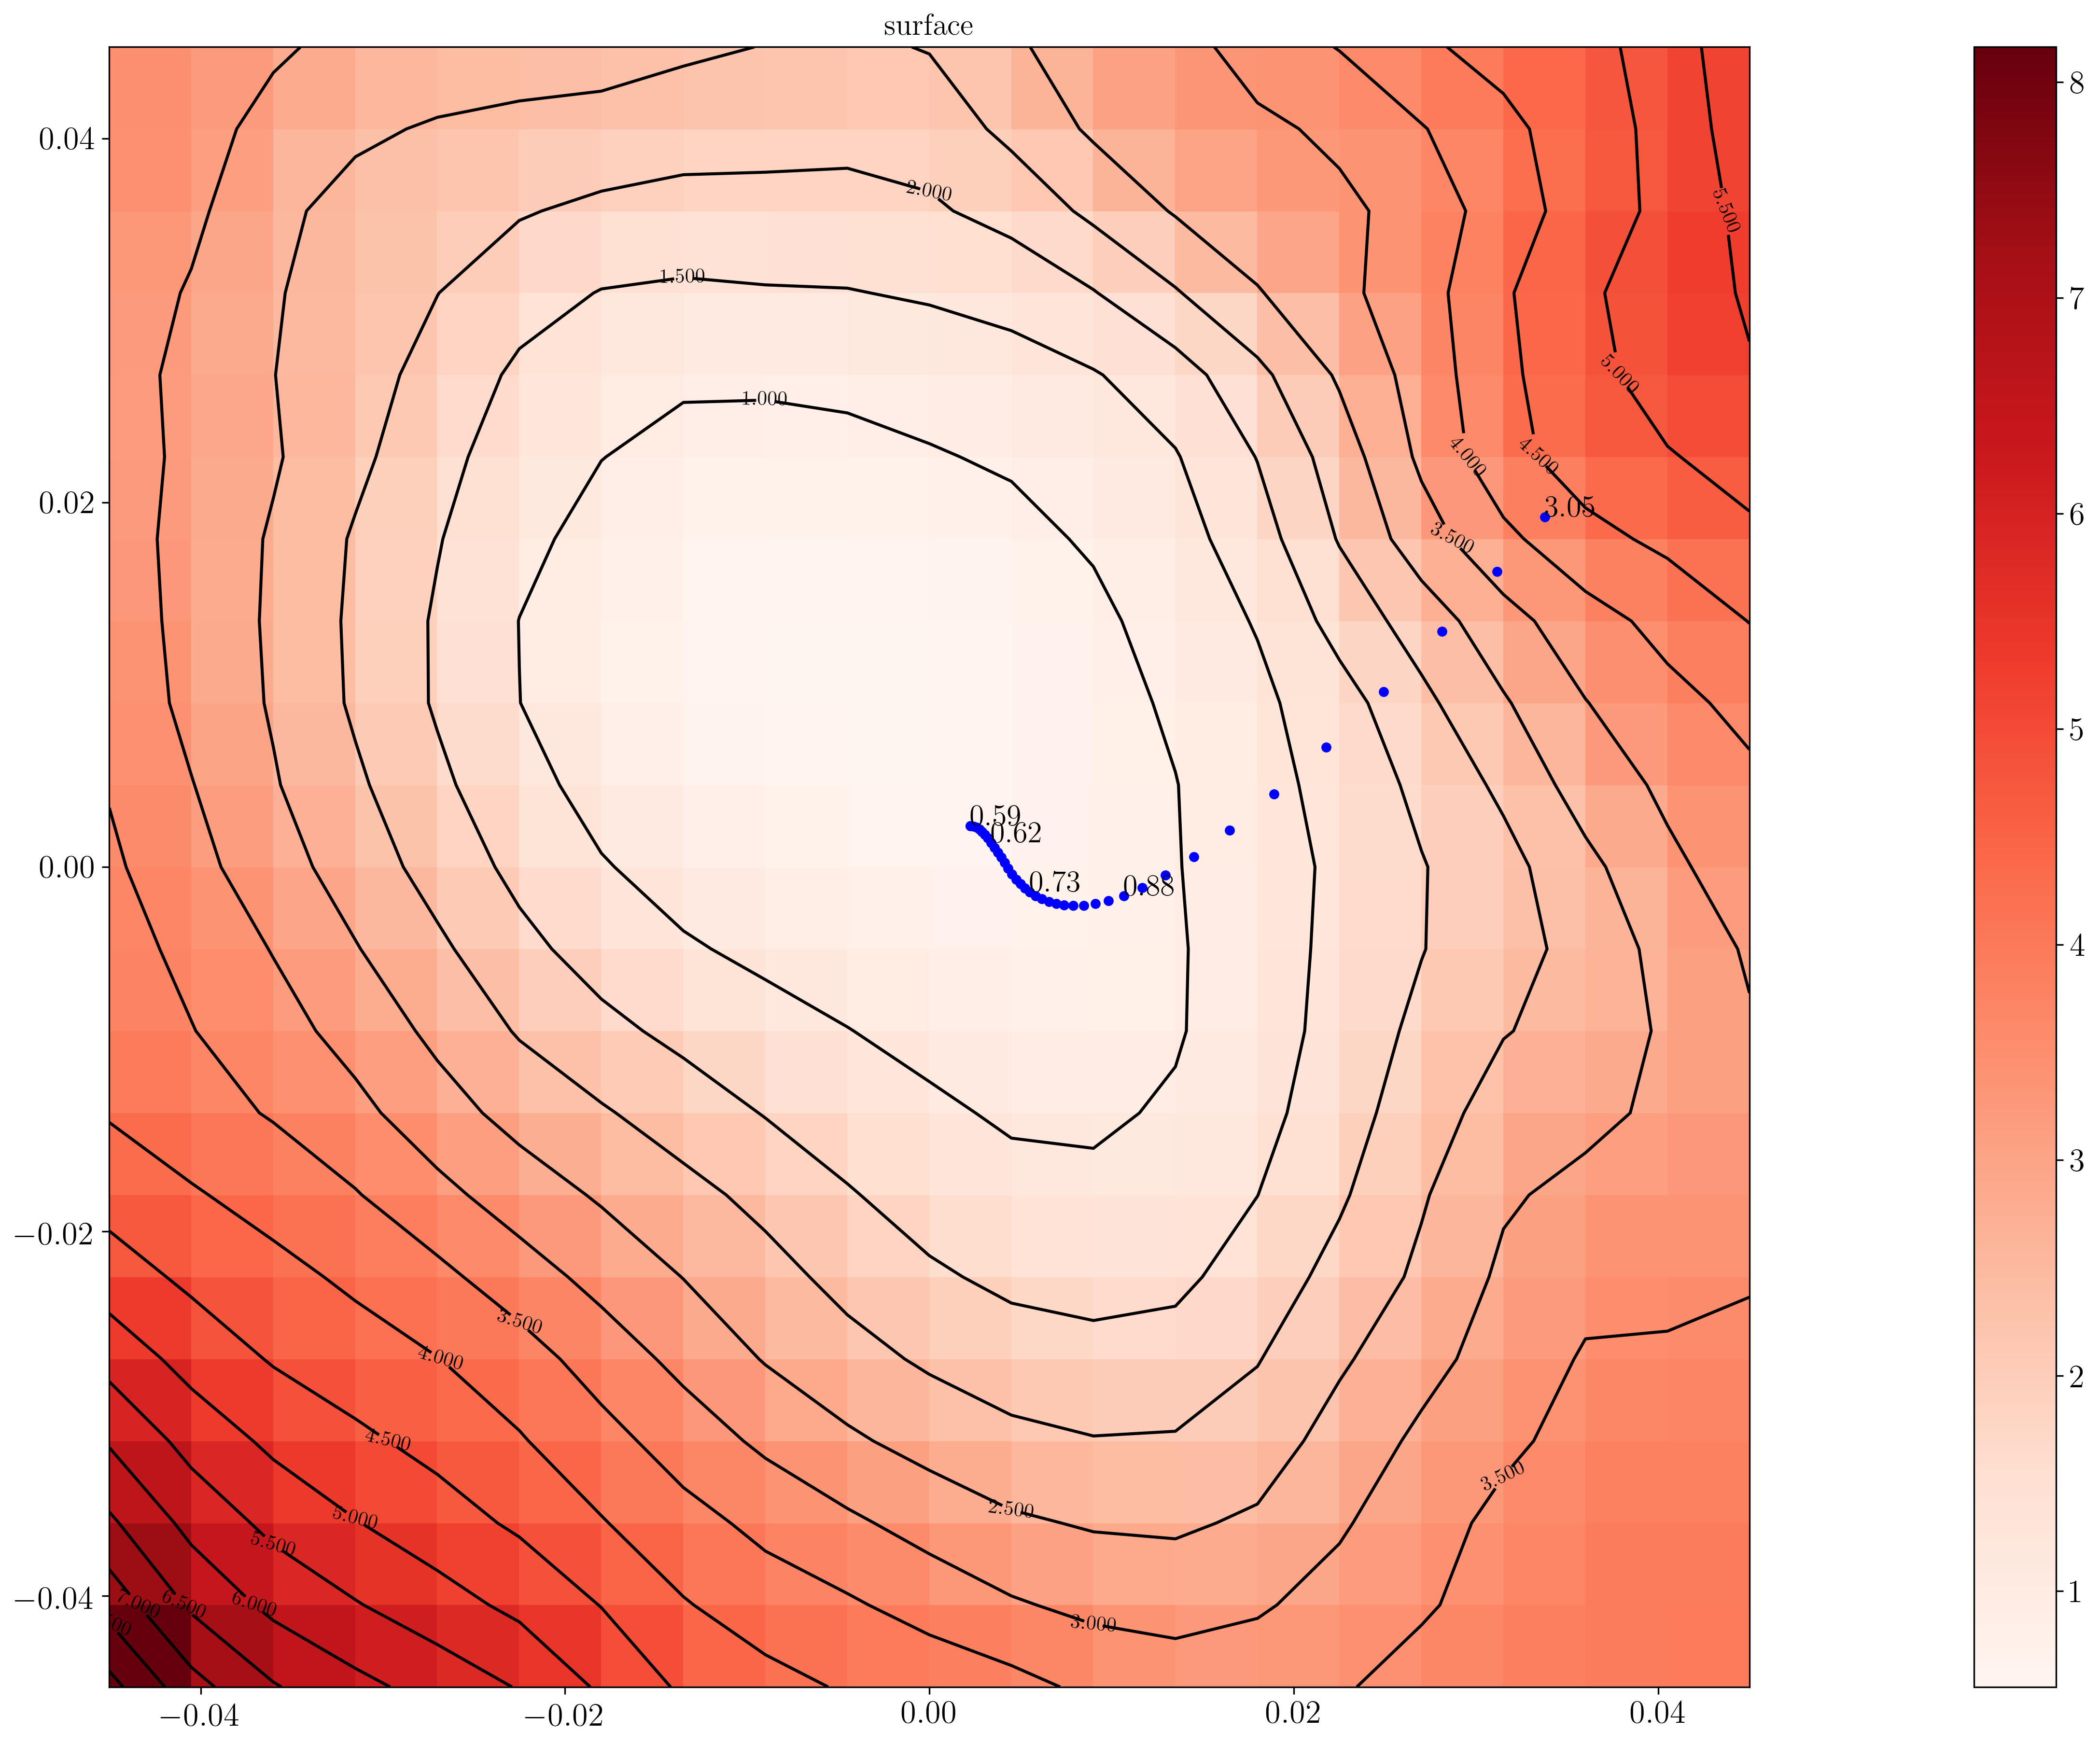

In [22]:
import matplotlib.pyplot as plt
from myhelpers import config_plots
config_plots.global_settings()

num_rows=1
num_columns=1
STEPS = coord_Tracker.steps_
DISTANCE = coord_Tracker.dist_

f, axes = plt.subplots(num_rows, num_columns, figsize=(40, 15), dpi= 300,)

X = np.array([(k - int(STEPS/2))*DISTANCE/STEPS for k in range(STEPS+1)])
# X = np.array([(k - int(STEPS/2)) for k in range(STEPS+1)])
Y = X
loss_data_fin = loss_data

ax = plt.subplot(num_rows, num_columns, 1)
contours = plt.contour(X, Y, loss_data_fin, 15, colors='black') # 
plt.clabel(contours, inline=True, fontsize=10)
plt.imshow(loss_data_fin, extent=[X[0], X[-1], Y[0], Y[-1]], origin='lower') # , cmap='RdGy', alpha=0.5
maxVal = np.amax([loss_data_fin])
minVal = np.amin([loss_data_fin])
plt.pcolor(X, Y, loss_data_fin, vmin=minVal, vmax=maxVal, cmap='Reds')
plt.colorbar()

ax.title.set_text('surface') 

wm_center = loss_landscapes.wrap_model(models[-1]).get_module_parameters()

for i in range(len(models)):
    wm_ = loss_landscapes.wrap_model(models[i])
    wm = wm_.get_module_parameters()
    scaled_model = scale_model(wm, wm_center, coord_Tracker.scaled_dirs_, normalize, DISTANCE, STEPS)
    plt.plot(scaled_model[0], scaled_model[1], marker='o', markersize=4, color='blue')
    value = round(metric(wm_).item(),2)
    if i%10 == 0 or i==len(models)-1:
        plt.text(scaled_model[0], scaled_model[1], value, fontdict={'size'   : 15})

In [20]:
f.savefig(os.path.join(coord_Tracker_path, "surface_fig.pdf"))